<a href="https://colab.research.google.com/github/ravioli21/Visual-Microphone/blob/main/visualMicrophoneFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
from scipy import signal
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
from scipy.io.wavfile import write

!pip install pyrtools
from google.colab import drive
import pyrtools as pt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
video_dir = "/content/drive/MyDrive/Chips2-2200Hz-Mary_MIDI-input.avi"
video=cv.VideoCapture(video_dir)

In [ ]:
def get_scaled_sound(sound):
  maxv = np.max(sound)
  minv = np.min(sound)

  if maxv != 1.0 or minv != -1.0:
    rangev = maxv - minv
    sound = 2 * sound / rangev
    newmax = np.max(sound)
    offset = newmax - 1.0
    sound -= offset

  return sound

In [ ]:
def v2s(video,nscale,norientation,downsample_factor):
  nframes=int(video.get(cv.CAP_PROP_FRAME_COUNT))
  suc,frame = video.read()
  if downsample_factor < 1:
    scaled_frame = cv.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
  else:
    scaled_frame = frame
  
  gray_frame = cv.cvtColor(scaled_frame, cv.COLOR_BGR2GRAY)
  norm_frame = cv.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)

  first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame,nscale,norientation-1,is_complex=True)
  first_pyr=first_pyr.pyr_coeffs
  first_coeff=dict()
  recovered_signal=dict()
  for band,coefficient in first_pyr.items():
      first_coeff[band]=coefficient
      # print("band ",band)
      # print("coefficient ",coefficient)
      recovered_signal[band]=list()
  

  iter=1;
  while suc:
    # suc,frame = video.read()
      iter+=1
      if downsample_factor < 1:
         frame = cv.resize(frame, (0,0), fx=downsample_factor, fy=downsample_factor)
      
      gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
      norm_frame = cv.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
      pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1, is_complex=True)
      pyramid=pyramid.pyr_coeffs
      amp_pyr=dict()

      for band,coefficient in pyramid.items():
         amp_pyr[band] = abs(coefficient)
      
      phase_diff_pyr = dict()

      for band,coefficient in pyramid.items():
         phase_diff_pyr[band] = np.mod(math.pi + np.angle(coefficient)-np.angle(first_coeff[band]),2*math.pi) - math.pi

      for band in pyramid.keys():
          amp=amp_pyr[band]
          phase_diff=phase_diff_pyr[band]
          lms=np.multiply(phase_diff, np.multiply(amp, amp))
          amp_net = np.sum(amp.flatten())
          recovered_signal[band].append(np.mean(lms.flatten())/amp_net)
      suc,frame=video.read()
    
  recov_sound=np.zeros(nframes)
  try:
    for rsignal in recovered_signal.values():
        recov_sound+=align(np.array(rsignal),np.array(recovered_signal[(0,0)]))
  except:
    print("error")
 
  sos = signal.butter(3, 0.05, btype='highpass', output='sos')
  filtered_sound = signal.sosfilt(sos, recov_sound)
  filtered_sound = get_scaled_sound(filtered_sound)
  return filtered_sound    

In [ ]:
x=v2s(video,1,2,0.1)
print(x)

[-1.          1.          0.91362054 ...  0.50469719  0.53129897
  0.47056064]


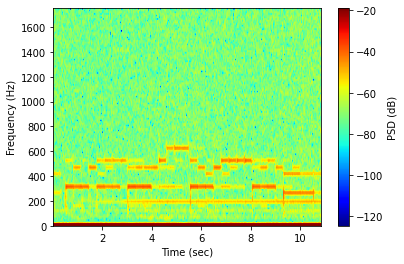

In [ ]:
  plt.figure()
  plt.specgram((x), Fs=3500, cmap=plt.get_cmap('jet'))
  plt.xlabel('Time (sec)')
  plt.ylabel('Frequency (Hz)')
  plt.colorbar().set_label('PSD (dB)')

In [ ]:
write('output.wav', 3500, get_scaled_sound(x))

In [ ]:
def get_soud_spec_sub (x: np.array):
    _, _, st = signal.stft(x)
    print(st.shape)
    
    stmags = np.multiply(np.abs(st), np.abs(st))
    print(stmags.shape)
    stangles = np.angle(st)
    print(stangles.shape)
    
    hold_col = np.quantile(stmags, 0.5, axis=1)
    print(hold_col.shape)
    
    for q in range(stmags.shape[1]):
        stmags[:, q] -= hold_col
        stmags [:, q] = np.maximum(stmags[:,q], 0)
    
    stmags = np.sqrt(stmags)
    newst = np.multiply(stmags, 1j * stangles)
    
    _, new_x = signal.istft(newst)    
    maxsx = np.max(new_x)
    minsx = np.min(new_x)

    if maxsx != 1.0 or minsx != -1.0:
        rangesx = maxsx - minsx
        new_x = 2 * new_x / rangesx
        newmax = np.max(new_x)
        offset = newmax - 1.0
        new_x = new_x - offset
    
    return new_x  

(129, 299)
(129, 299)
(129, 299)
(129,)


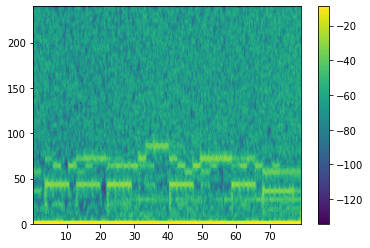

In [ ]:
plt.figure()
plt.specgram(get_soud_spec_sub(x), Fs=480, noverlap=150)
plt.colorbar()
plt.show()